In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, OPTICS, KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from functions import *
%matplotlib inline

# Import dei dati

In [2]:
#import dei pesi dei cluster
labels=np.loadtxt("../data/processed/CLUSTERING_weights.txt")

In [3]:
# import dei centroidi
data = pd.read_csv("../data/processed/CLUSTERING_data_centres.csv")
data.drop(labels='Unnamed: 0',inplace=True,axis=1)

In [4]:
pure_material_names,pure_materials = import_pure_spectra('../data/raw/Database Raman/BANK_LIST.dat','../data/raw/Database Raman/')

# Interpolazione

Ora devo interpolare gli spettri puri ai dati

In [5]:
pure_materials_interpoled=pd.DataFrame(data.wn.copy())
for temp in pure_material_names:
    pure_materials_interpoled=pure_materials_interpoled.join(pd.DataFrame(np.interp(data.wn, pure_materials[temp+'_wn'] ,pure_materials[temp+'_I']),columns=[temp]))

In [6]:
#Normalizzazione
for i in pure_material_names:
    pure_materials_interpoled[i]=pure_materials_interpoled[i]/np.trapz(abs(pure_materials_interpoled[i].dropna()), x=pure_materials_interpoled.wn)

# Fit

In [7]:
ols =LinearRegression(positive=True) #definisco il regressore

In [8]:
N_cluster=len(data.columns)-1
coeff=[]
intercept=[]
for i in range(N_cluster):
    ols.fit(pure_materials_interpoled[pure_material_names], data[str(i)])#ottimizziamo il modello (lineare) su i dati di training
    coeff.append(ols.coef_)
    intercept.append(ols.intercept_)


### Plot dei vari centroidi dei cluster e del rispettivo fit

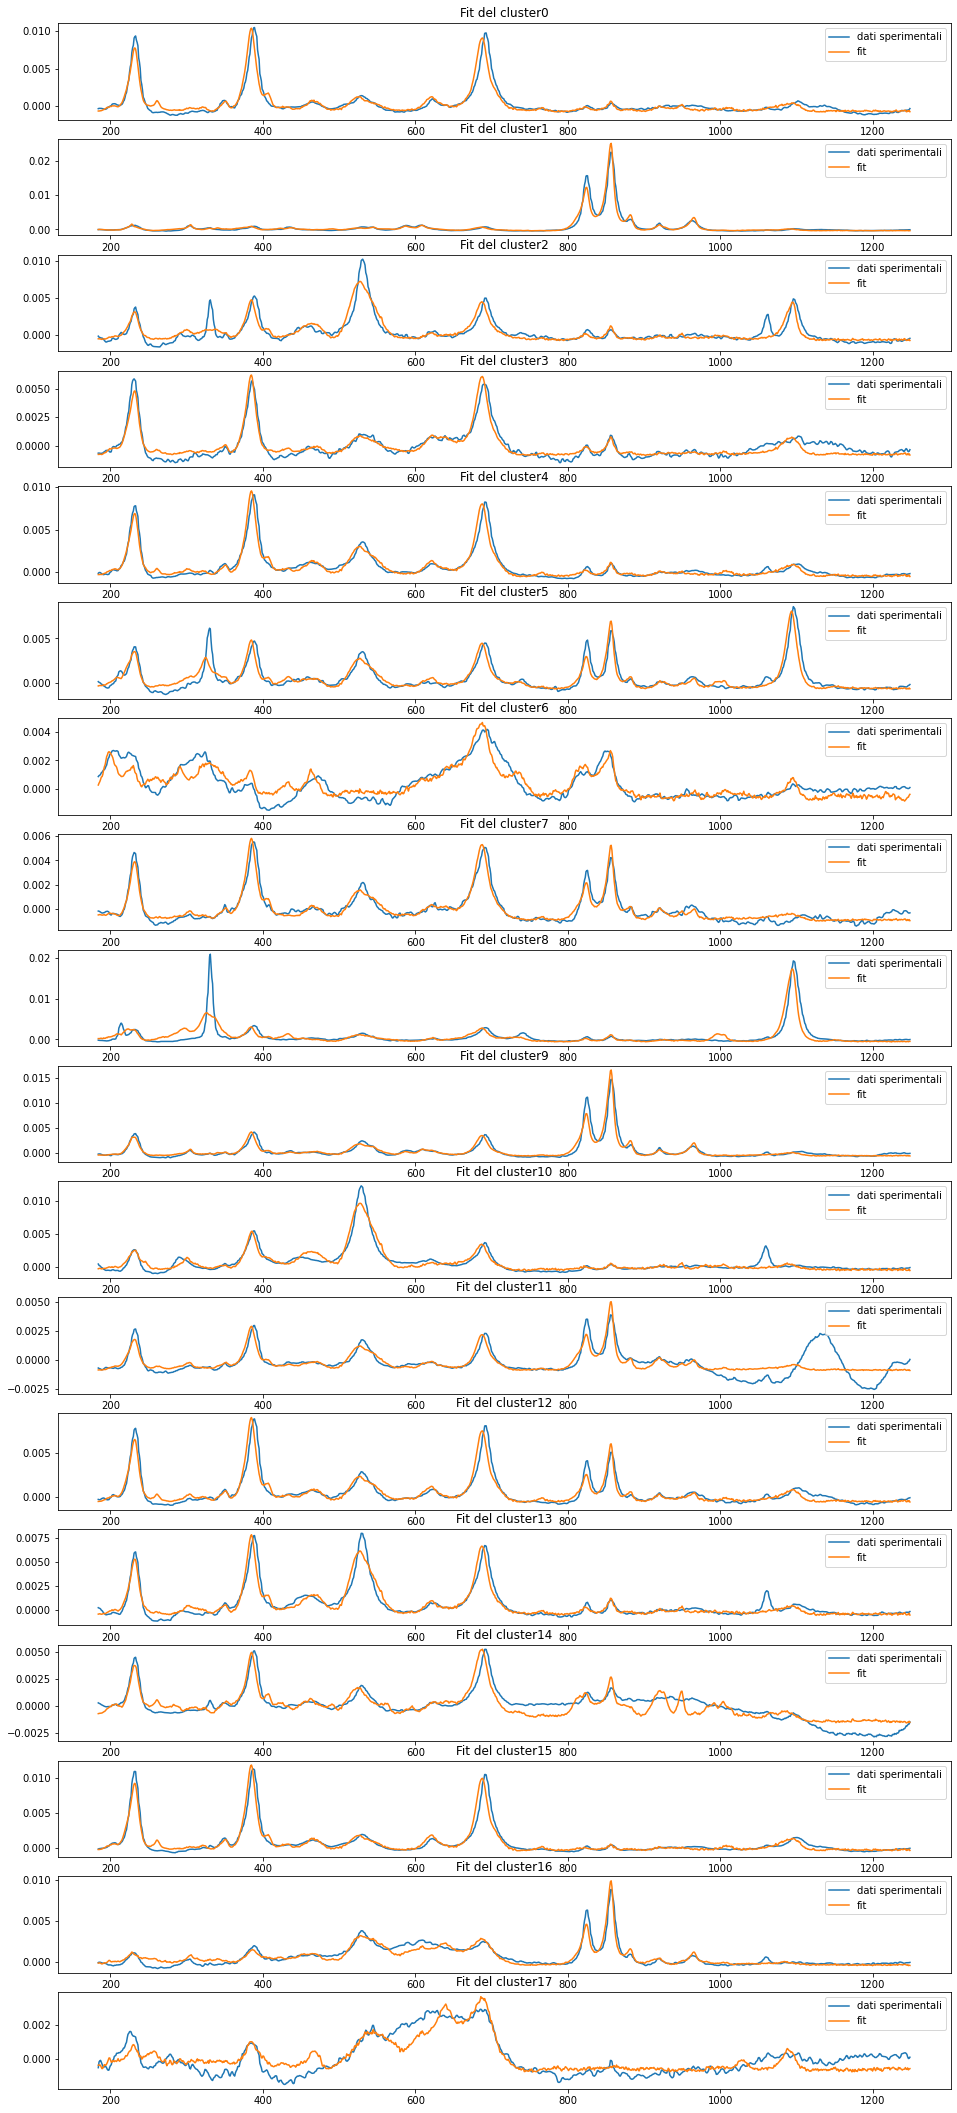

In [20]:
fig, axs = plt.subplots(nrows = N_cluster,figsize = (16,38))
for i in enumerate(range(N_cluster)):
    axs[i[0]].plot(data.wn,data[str(i[0])])
    axs[i[0]].plot(pure_materials_interpoled.wn,intercept[i[0]]+np.sum(pure_materials_interpoled[pure_material_names] * coeff[i[0]] ,axis=1))
    axs[i[0]].set_title('Fit del cluster' + str(i[0]))
    axs[i[0]].legend(['dati sperimentali','fit'], loc='upper right')

Ora, tenendo conto dei pesi dei clustering, sommo i coeficienti pesandoli e poi li normalizzo, in modo da trovare le percentuali.

In [12]:
#numero di spettri per cluster in ordine
weights=[np.count_nonzero(labels==i) for i in range(len(data.columns)-1)] 
#moltiplico i coeficienti del cluster i-esimo per questo numero
abbundances_notnormalized=[coeff[i]*weights[i] for i in range(len(data.columns)-1)]
#e infine ho la media pesata dei coeficienti
abbundances=sum(abbundances_notnormalized)/(sum(abbundances_notnormalized).sum())
#Creo un Pandas dataframe con nomi e abbondanze
abbundance_table=pd.DataFrame({'names':pure_material_names,'abbundances':abbundances})
#riordino in base alla concenrazione
abbundance_table.sort_values('abbundances',ascending=False,inplace=True)
abbundance_table.head(5)

,names,abbundances
12,Chrysotile,0.389803
19,Dwornikite,0.128661
24,Forsterite,0.120322
36,Magnesiochromite,0.037744
32,Jarosite,0.029193
